# ANALYSIS OF FOOTFALL DATA

The footfall data is a collection of total count of people in each ward within Westminster Borough. However, this data
does not provide count for all wards in Westminster, just a select few, namely, Hyde Park, Bryanston and Dorset Square,
West End, Marylebone High Street, St James's, and Not Recorded wards. People are counted using a sensor device called 'SmartStreetSensor', 
which are installed across an area in the wards stated above. Business within these wards are approached to host these 
devices, and in return can access to all data collected. The notable columns in this data is InCount, OutCount and 
ReportCount. The Incount counts people walking towards the sensor, specifically, people entering the premise where the 
device is installed. The OutCount counts people walking past the device, specifically, people who walk across shops but 
do not enter. And lastly, ReportCount is the sum of InCount and OutCount for that location. The data is collected 
continuosly in time. 

In [2]:
#importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd
import pysal
from shapely.geometry import Point
sns.set_style('whitegrid')

In [3]:
#reading in data
footfall = pd.read_csv('Footfall.csv')

In [4]:
#printing columns of the dataframe
footfall.columns

Index([u'DataOwner', u'Site', u'Location', u'Date', u'DayOfWeek',
       u'DayOfWeekNumber', u'Month', u'MonthNumber', u'Year', u'Week', u'Time',
       u'HourBand', u'Lat', u'Long', u'Street', u'Ward', u'StressArea',
       u'InCount', u'OutCount', u'ReportCount'],
      dtype='object')

In [5]:
#printing records of the data
footfall.head(1)

,DataOwner,Site,Location,Date,DayOfWeek,DayOfWeekNumber,Month,MonthNumber,Year,Week,Time,HourBand,Lat,Long,Street,Ward,StressArea,InCount,OutCount,ReportCount
0,Spring Board,Heart of London BID,Shaftesbury Avenue,2016-02-05,Fri,5,Feb,2,2016,WK06,00:00,00:00 - 01:00,-1.0,-1.0,Not Recorded,Not Recorded,Not Recorded,296,188,484


In [6]:
#checking the number of wards where footfall count was conducted
footfall.Ward.unique()

array(['Not Recorded', 'Hyde Park', 'Bryanston and Dorset Square',
       'West End', 'Marylebone High Street', 'St James`s'], dtype=object)

In [7]:
#making a copy of the dataframe so as to keep the original intact in the event where series of modification has to be
#made to the data
ftfl = footfall.copy()

In [8]:
#selecting attributes of interest for analysis
foot = ftfl.ix[:,['InCount', 'OutCount','ReportCount']]

# SECTION A

# COMPARING InCount to OutCount

It is possible for the sensor device to count people walking past a shop without entering. In order to get a general 
overview where Incount exceeds OutCount, to show how business in those locations are patronised, I created a new 
column which returns a boolean if Incount is greater than OutCount.

In [9]:
#creating a new column called compare, which is a boolean stating where incount is greater or less than outcount
foot['compare'] = foot[['InCount','OutCount']].apply(lambda x: 1 if x['InCount'] > x['OutCount'] else 0, axis=1)

In [10]:
#counting the number of ones in the dataframe
count_ones = foot[foot.compare== 1].count()['compare']

In [11]:
#printing results
count_ones

303675

In [12]:
#counting the number of zeros in the dataframe
count_zeros = foot[foot.compare== 0].count()['compare']

In [13]:
#printing results
count_zeros

396573

From the above statistics, it can be observed that the wards in question, Hyde Park, Bryanston and Dorset Square, 
West End, Marylebone High Street, and St James's saw more people walk past a premise as opposed to entering. The figure shows that for each location, Incount was 303675 compared to OutCount which was 396573. This figure is not the
total number of people entering or walking past a premise, rather, the number of times an InCount exceeded OutCount and vice versa was recorded for all locations for all locations combined. 

NB: Some wards were not recorded, and those are labelled Not Recorded 

In [14]:
#computing sum of all counts into a premise for the whole period that the data was collected. 
total_in = foot.InCount.sum()

In [15]:
#printing results
total_in

288262200

In [16]:
#computing sum of all counts of people walking past the device for the whole period that the data was collected. 
total_out = foot.OutCount.sum()

In [17]:
#printing results
total_out

288007814

The above results shows that more people walked into a premise compared to walking past, as InCount total was 288,262,200
compared to OutCount which was 288,007,814. These figures are for all recorded and not recorded wards.

In [18]:
#computing the total count of people picked up by the sensor device, both InCount and OutCount  
total = footfall.ReportCount.sum()

In [19]:
#printing results 
total

607003438

# SECTION B

# CHECKING FOR ANOMALIES IN THE DATASET WITH RESPECT TO COUNTS

From the above computations, it can be observed that the total InCount figure was less than OutCount, although the 
number of times InCount was recorded was less than OutCount, which intuitively should lead to overall less InCount total
compared to OutCount. This might not necessarily be the case as InCount figures recorded for each location may be more than OutCount, so even if the number of times InCount was recorded for all locations was less than OutCount, it will not necessarily lead to a less total figure.
However, it is important to check if there are any missing records in the data which might not give the true report count for InCount and OutCount. The below computations will provide the answer to this question.

In [20]:
#Computing the total count using InCount and OutCount and assigning results to new column
foot['TotalCount'] = foot.InCount + foot.OutCount

In [21]:
#checking mismatched rows where the reported count do not add up to actual total count using both
#InCount and OutCount
test = foot[foot.ReportCount != foot.TotalCount].count()['ReportCount']

In [22]:
#printing results
test

87260

In [23]:
#counting number of rows where InCount has zeros
(foot['InCount'] == 0).sum()

114082

In [24]:
#counting number of rows where InCount has non-zeros
(foot['InCount'] != 0).sum()

586166

In [25]:
#counting number of rows where OutCount has zeros
(foot['OutCount'] == 0).sum()

112169

In [26]:
#counting number of rows where OutCount has non-zeros
(foot['OutCount'] != 0).sum()

588079

In [27]:
#checking how many rows with zeros where correctly computed for ReportCount column
foot[(foot.InCount == 0) & (foot.OutCount == 0) & (foot.ReportCount == 0)].count()['ReportCount']

18285

The footfall dataset has 700248 rows. From the above computations, there was a total of 87,260 rows which did not match 
the totalcount column which is the correct sum of InCount and OutCount. The total number of zeros entered in the 
InCount column is 114,082 and that of OutCount is 112,169. The ReportCount column shows entries made but there were 
zero entries in InCount and OutCount, which should give zero ReportCount. My result shows that a total of 18,285 rows in 
InCount and OutCount columns correctly matched ReportCount (sum of InCount and OutCount).

# SECTION C

# ANALYSING THE DATASET IN ORDER TO EXTRACT INFORMATION ABOUT TRENDS AND CORRELATION IF ANY

ANALYSIS WILL CONSIST OF THE FOLLOWING:

    Footfall and festivities. That is, showing how festivities such as Christmas and Ramadan impact on the number of 
    people counted in each BID or ward. Whether both festivities lead to increase in numbers for a particular 
    period as picked up the the sensor device or otherwise.
    
    Which BID saw the most visitors
    
    What time of the evening and night are busiest.

In [28]:
#making a copy of data to use in analysis since modification will be made on the data, and we do not want to 
#keep the contents of the original data as it is.
fest_foot = footfall.copy()

In [29]:
#selecting attributes of interest
fest_df = fest_foot.ix[:,['Date','Time', 'Month','Long','Lat' ,'Year','Ward','StressArea','InCount','OutCount','TotalCount']]

In [30]:
#assigning sum of InCount and OutCount to new column TotalCount
fest_df['TotalCount'] = fest_df.InCount + fest_df.OutCount

I have chosen the Christmas festive week to be from 18-24 December for the years 2015 and 2016, since the Christmas 
day 25th December is fixed. However, this is not the case of Eid al-Fitr (festival of celebration for Muslims
after their fast-Ramadan), as the day is set according to the moon. For 2015, Eid fell on 17th July, so I set the 
festive week as 11-16 July, and for 2016 the festive week set is 30th June to 5th July.

In [31]:
#extracting Christmas week 
xmas_2016 = fest_df[fest_df['Date'].between('2016-12-18', '2016-12-24', inclusive=True)]
xmas_2015 = fest_df[fest_df['Date'].between('2015-12-18', '2015-12-24', inclusive=True)]

In [32]:
#computing counts per ward
ward_count_2016 = xmas_2016.groupby(['Ward'])['InCount','OutCount','TotalCount'].sum()
ward_count_2015 = xmas_2015.groupby(['Ward'])['InCount','OutCount','TotalCount'].sum()

In [33]:
#printing results
ward_count_2016

,InCount,OutCount,TotalCount
Ward,,,
Bryanston and Dorset Square,125295,109896,235191
Hyde Park,0,0,0
Marylebone High Street,1023944,1086033,2109977
St James`s,208092,192828,400920
West End,2125927,2119438,4245365


In [34]:
#printing results
ward_count_2015

,InCount,OutCount,TotalCount
Ward,,,
Bryanston and Dorset Square,147474,134981,282455
Marylebone High Street,991731,976011,1967742
Not Recorded,103209,93237,196446
St James`s,736702,693665,1430367
West End,2113485,2247040,4360525


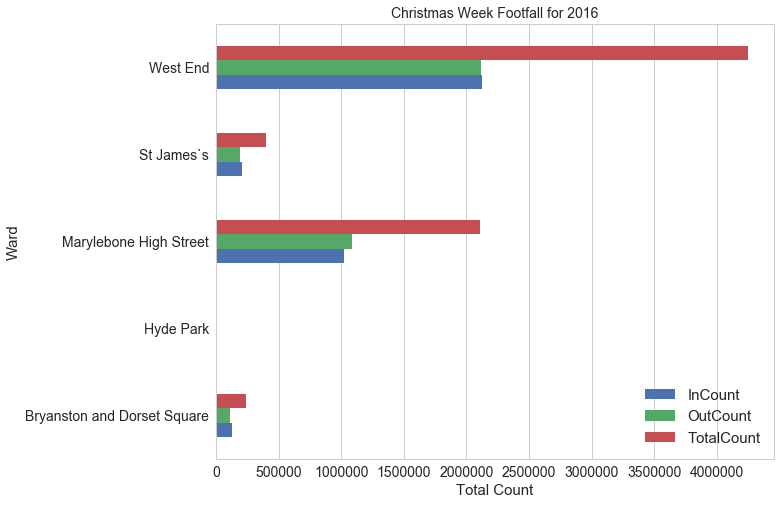

In [35]:
#plotting results
ward_count_2016.plot(kind='barh',figsize=(10,8), fontsize=14)
plt.title('Christmas Week Footfall for 2016', fontsize=14)
plt.xlabel('Total Count', fontsize=15)
plt.ylabel('Ward',fontsize=15)
plt.grid(False,axis='y')
plt.legend(fontsize=15)

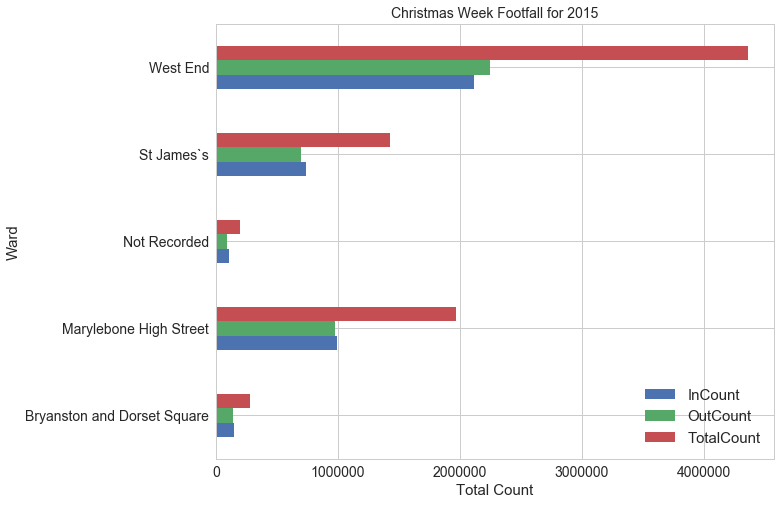

In [36]:
#plotting results
ward_count_2015.plot(kind='barh',figsize=(10,8), fontsize=14)
plt.title('Christmas Week Footfall for 2015', fontsize=14)
plt.xlabel('Total Count', fontsize=15)
plt.ylabel('Ward',fontsize=15)
plt.legend(fontsize=15)

In [37]:
#extracting Eid week 
eid_2016 = fest_df[fest_df['Date'].between('2016-06-30', '2016-07-05', inclusive=True)]

Since there was no footfall record in July to compute count of people during Muslim Eid, no analysis will made for 2015

In [38]:
#footfall for 2015 started from the month of November. The output below confirms it.
fest_df[fest_df.Date.str.contains('2015')].head()

,Date,Time,Month,Long,Lat,Year,Ward,StressArea,InCount,OutCount,TotalCount
1008,2015-11-06,00:00,Nov,-1.0,-1.0,2015,Not Recorded,Not Recorded,340,209,549
1009,2015-11-02,00:00,Nov,-1.0,-1.0,2015,Not Recorded,Not Recorded,175,152,327
1010,2015-11-07,00:00,Nov,-1.0,-1.0,2015,Not Recorded,Not Recorded,673,400,1073
1011,2015-11-08,00:00,Nov,-1.0,-1.0,2015,Not Recorded,Not Recorded,927,541,1468
1012,2015-11-05,00:00,Nov,-1.0,-1.0,2015,Not Recorded,Not Recorded,183,117,300


In [39]:
#computing counts per ward
ward_count_2016_eid = eid_2016.groupby(['Ward'])['InCount','OutCount','TotalCount'].sum()

In [40]:
#printing results
ward_count_2016_eid

,InCount,OutCount,TotalCount
Ward,,,
Bryanston and Dorset Square,113933,103080,217013
Hyde Park,0,0,0
Marylebone High Street,815111,810304,1625415
Not Recorded,64240,57080,121320
St James`s,526782,513252,1040034
West End,1797387,1777225,3574612


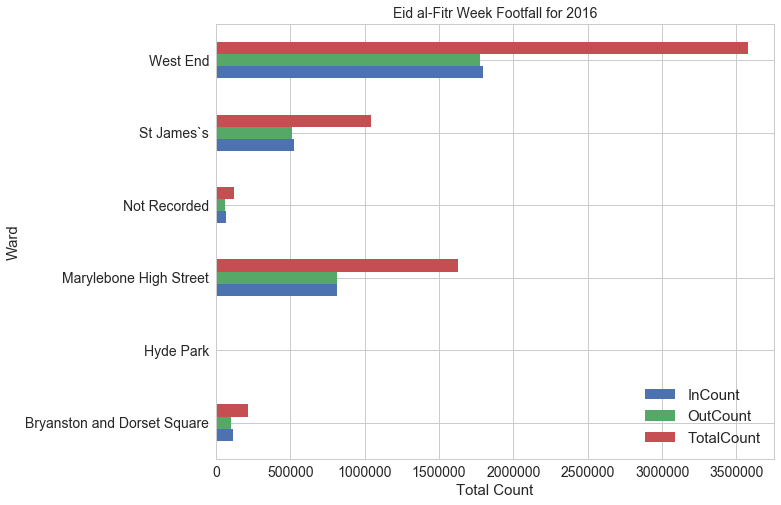

In [41]:
#plotting results
ward_count_2016_eid.plot(kind='barh',figsize=(10,8), fontsize=14)
plt.title('Eid al-Fitr Week Footfall for 2016', fontsize=14)
plt.xlabel('Total Count', fontsize=15)
plt.ylabel('Ward',fontsize=15)
plt.legend(fontsize=15)

Comparing the festivity week to the footfall, Christmas saw a high number counts for both 2015 and 2016, compared to 
Eid for the West End ward. The figures for Christmas in 2015 and 2016 were 4,360,525 and 4,245,365 respectively, and that of Eid for 2016 was 3,574,612 and nothing recorded for 2015.

Non-festive week leading to the Christmas week

    It is important to know the difference in numbers between the festive week as stated above and non-festive week. 
    The difficulty with this analysis is getting the right period to compare the festive period with. Choosing the
    week prior to the festive week will not give a good trend as the difference in the count might be neglible as it
    is too close to the period chosen as the festive week. To have a fair and balanced comparison, I chose the month
    of November and picked the last week, matching the same number of days in the festive week. Below are the results:

In [42]:
#extracting non festive week prior to Christmas week 
prior_xmas_2016 = fest_df[fest_df['Date'].between('2016-11-25', '2016-11-30', inclusive=True)]
prior_xmas_2015 = fest_df[fest_df['Date'].between('2015-11-25', '2015-11-30', inclusive=True)]

In [43]:
#computing counts per ward
prior_ward_count_2016 = prior_xmas_2016.groupby(['Ward'])['InCount','OutCount','TotalCount'].sum()
prior_ward_count_2015 = prior_xmas_2015.groupby(['Ward'])['InCount','OutCount','TotalCount'].sum()

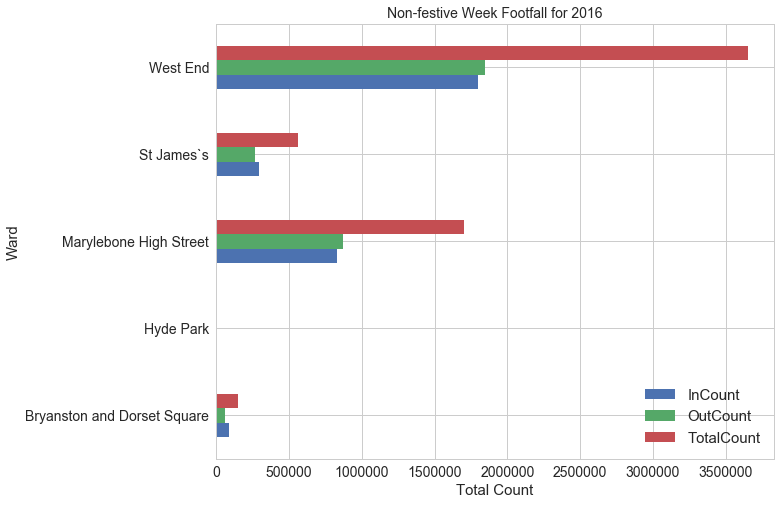

In [44]:
#plotting results
prior_ward_count_2016.plot(kind='barh',figsize=(10,8), fontsize=14)
plt.title('Non-festive Week Footfall for 2016', fontsize=14)
plt.xlabel('Total Count', fontsize=15)
plt.ylabel('Ward',fontsize=15)
plt.legend(fontsize=15)

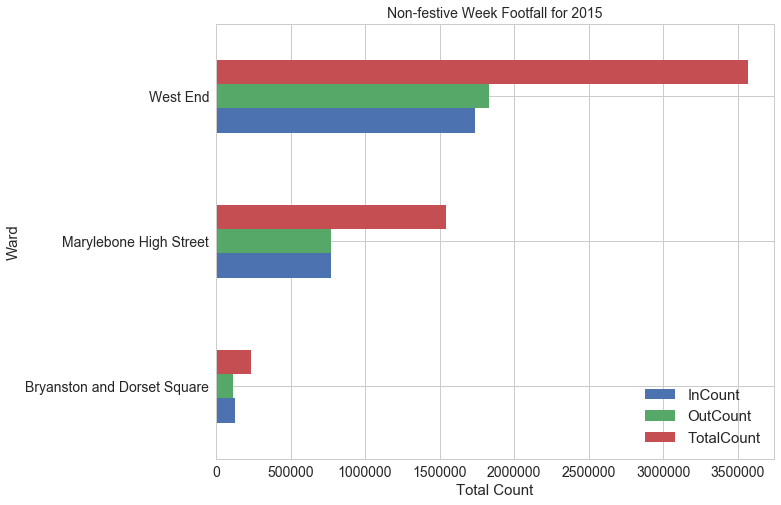

In [45]:
#plotting results
prior_ward_count_2015.plot(kind='barh',figsize=(10,8), fontsize=14)
plt.title('Non-festive Week Footfall for 2015', fontsize=14)
plt.xlabel('Total Count', fontsize=15)
plt.ylabel('Ward',fontsize=15)
plt.legend(fontsize=15)

Non-festive week leading to the Eid week

In [46]:
#extracting non-festive week prior to Eid week 
prior_eid_2016 = fest_df[fest_df['Date'].between('2016-06-01', '2016-06-06', inclusive=True)]

In [47]:
#computing counts per ward
prior_ward_count_2016_eid = prior_eid_2016.groupby(['Ward'])['InCount','OutCount','TotalCount'].sum()

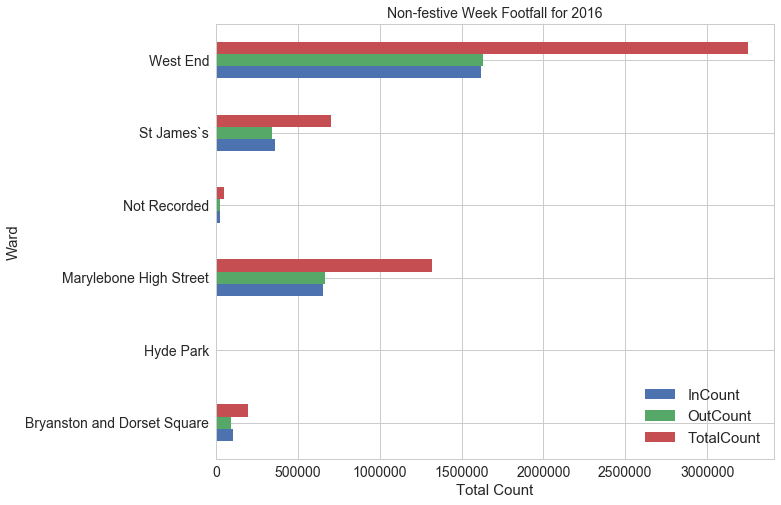

In [48]:
#plotting results
prior_ward_count_2016_eid.plot(kind='barh',figsize=(10,8), fontsize=14)
plt.title('Non-festive Week Footfall for 2016', fontsize=14)
plt.xlabel('Total Count', fontsize=15)
plt.ylabel('Ward',fontsize=15)
plt.legend(fontsize=15)

BID (Business Improvement District) is formed following a formal ballot of businesses in a defined area, based upon a detailed proposal of projects and services to be provided. Income is raised through a mandatory BID levy on
businesses occupying properties above a particular rateable value. A majority voting in favour by both
number and rateable value is necessary for the ballot to be successful and the BID established. The objective of the BID is to provide services that businesses want to create a strong retail, employment and tourist attraction to the
area (Reference: http://marble-arch.london/wordpress-2016/wp-content/uploads/2016/01/MarbleArch_BID_Proposal.pdf)

It will be interesting to see how the numbers compare for each BID. The analysis below will show how many people were
captured by the sensor device in each BID over a time period. This will help inform businesses on patronage to the area. 

In [49]:
#computing counts of people with respect to BID
bid = fest_foot.ix[:,['Site','Date','Month','Year','Ward','InCount','OutCount']]

In [50]:
#assigning sum of InCount and OutCount to new column TotalCount
bid['TotalCount'] = bid.InCount + bid.OutCount

In [51]:
#selecting years to include in analysis
bid_15_16 = bid[bid['Year'].between(2015, 2016, inclusive=True)]

In [52]:
#computing counts per ward
bid_count = bid_15_16.groupby(['Site','Year','Ward'])['InCount','OutCount','TotalCount'].sum()

In [53]:
#printing results
bid_count

InCount  OutCount  \
Site                Year Ward                                              
Heart of London BID 2015 Not Recorded                  2758513   2523244   
                         St James`s                   13657344  13322365   
                         West End                       831860    741897   
                    2016 Not Recorded                  3380217   3064028   
                         St James`s                   14857482  14633953   
                         West End                      1064221    983626   
London New West End 2015 Bryanston and Dorset Square   2943967   2606969   
                         Marylebone High Street       19451577  19708359   
                         West End                     43925026  45460431   
                    2016 Bryanston and Dorset Square   6329892   5833227   
                         Marylebone High Street       43088361  44315214   
                         West End                     98406043  98431717   
Marble Arch BID     2016 Bryanston and Dorset Square         0         0   
                         Hyde Park                           0         0   
                         West End                            0         0   
Northbank BID       2015 St James`s                     262406    220407   
                    2016 St James`s                   14038763  12744401   

                                                      TotalCount  
Site                Year Ward                                     
Heart of London BID 2015 Not Recorded                    5281757  
                         St James`s                     26979709  
                         West End                        1573757  
                    2016 Not Recorded                    6444245  
                         St James`s                     29491435  
                         West End                        2047847  
London New West End 2015 Bryanston and Dorset Square     5550936  
                         Marylebone High Street         39159936  
                         West End                       89385457  
                    2016 Bryanston and Dorset Square    12163119  
                         Marylebone High Street         87403575  
                         West End                      196837760  
Marble Arch BID     2016 Bryanston and Dorset Square           0  
                         Hyde Park                             0  
                         West End                              0  
Northbank BID       2015 St James`s                       482813  
                    2016 St James`s                     26783164

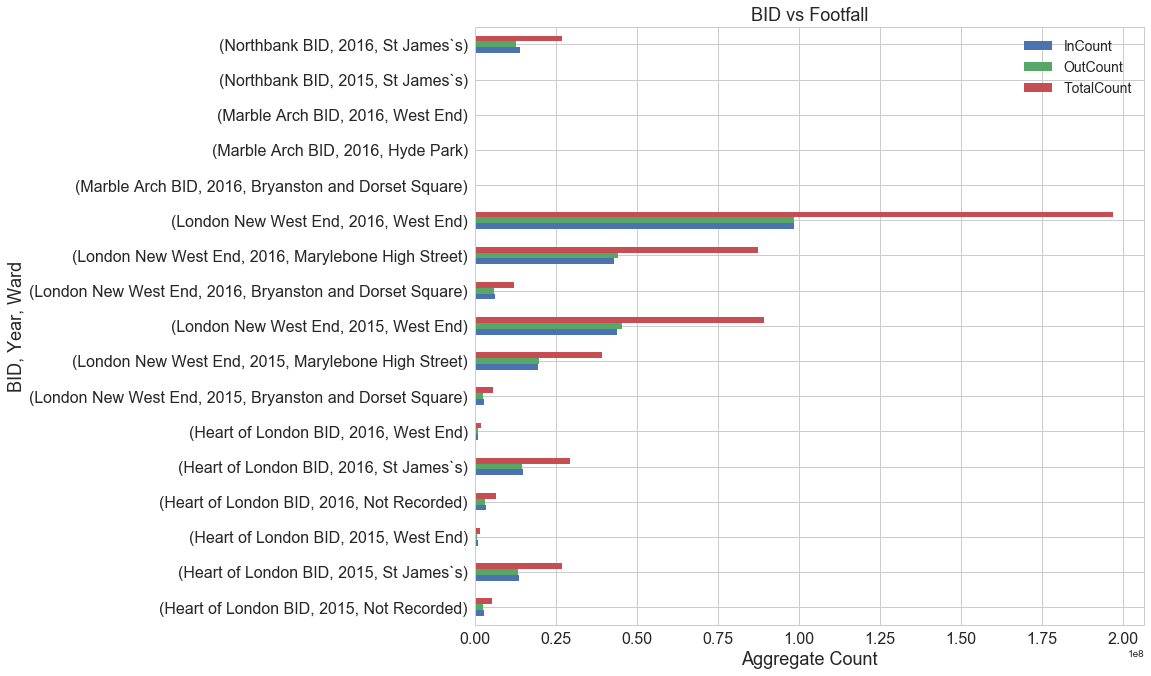

In [54]:
#plotting footfall for each BID in the data
bid_count.plot(kind='barh', figsize=(12,11), fontsize=16)
plt.title('BID vs Footfall', fontsize=18)
plt.ylabel('BID, Year, Ward', fontsize=18)
plt.xlabel('Aggregate Count', fontsize=18)
plt.legend(fontsize=14)

From the above plot, it can be observed that the BID which received the most number of visitors was London New West End
in the year 2016. The corresponding ward for this BID was West End, which is no surprise, given the previous plots for 
footfall for the festive seasons.

Evening and Night Time footfall analysis. The evening period is from 1800hrs to 2000hrs, whilst, night period is from
2000hrs to 0400hrs.

In [55]:
#extracting attributes of interest
eve_night  = fest_foot.ix[:,['Time','Ward','InCount','OutCount']]

In [56]:
#assigning sum of InCount and OutCount to new column TotalCount
eve_night['TotalCount'] = eve_night.InCount + eve_night.OutCount

In [57]:
#selecting time for evening and night
evening = eve_night[eve_night['Time'].between('18:00', '20:00', inclusive=True)]
night = eve_night[(eve_night.Time > '20:00')]

In [58]:
#computing counts per time and ward
eve_count = evening.groupby(['Time','Ward'])['InCount','OutCount','TotalCount'].sum()

In [59]:
#printing results
eve_count

InCount  OutCount  TotalCount
Time  Ward                                                       
18:00 Bryanston and Dorset Square    901063    782982     1684045
      Hyde Park                           0         0           0
      Marylebone High Street        5977877   6268317    12246194
      Not Recorded                   488418    508237      996655
      St James`s                    4193527   3687538     7881065
      West End                     13610894  12998879    26609773
19:00 Bryanston and Dorset Square    724767    594721     1319488
      Hyde Park                           0         0           0
      Marylebone High Street        4350161   4411807     8761968
      Not Recorded                   357465    378800      736265
      St James`s                    2884049   2725876     5609925
      West End                      9421661   8926099    18347760
20:00 Bryanston and Dorset Square    603511    419553     1023064
      Hyde Park                           0         0           0
      Marylebone High Street        3274057   3250861     6524918
      Not Recorded                   291228    243214      534442
      St James`s                    2094217   1992947     4087164
      West End                      6516232   5938768    12455000

In [60]:
#computing counts per time and ward
night_count = night.groupby(['Time','Ward'])['InCount','OutCount','TotalCount'].sum()

In [61]:
#printing results
night_count

InCount  OutCount  TotalCount
Time  Ward                                                      
21:00 Bryanston and Dorset Square   498238    247154      745392
      Hyde Park                          0         0           0
      Marylebone High Street       2191470   2159030     4350500
      Not Recorded                  266376    177142      443518
      St James`s                   1792380   1724616     3516996
      West End                     4457225   3641034     8098259
22:00 Bryanston and Dorset Square   487399    162394      649793
      Hyde Park                          0         0           0
      Marylebone High Street       1517668   1327335     2845003
      Not Recorded                  343019    147973      490992
      St James`s                   1826803   1890252     3717055
      West End                     3273393   2431278     5704671
23:00 Bryanston and Dorset Square   378628    125782      504410
      Hyde Park                          0         0           0
      Marylebone High Street        948260    869310     1817570
      Not Recorded                  211230     97411      308641
      St James`s                   1253131   1267109     2520240
      West End                     2047593   1560501     3608094

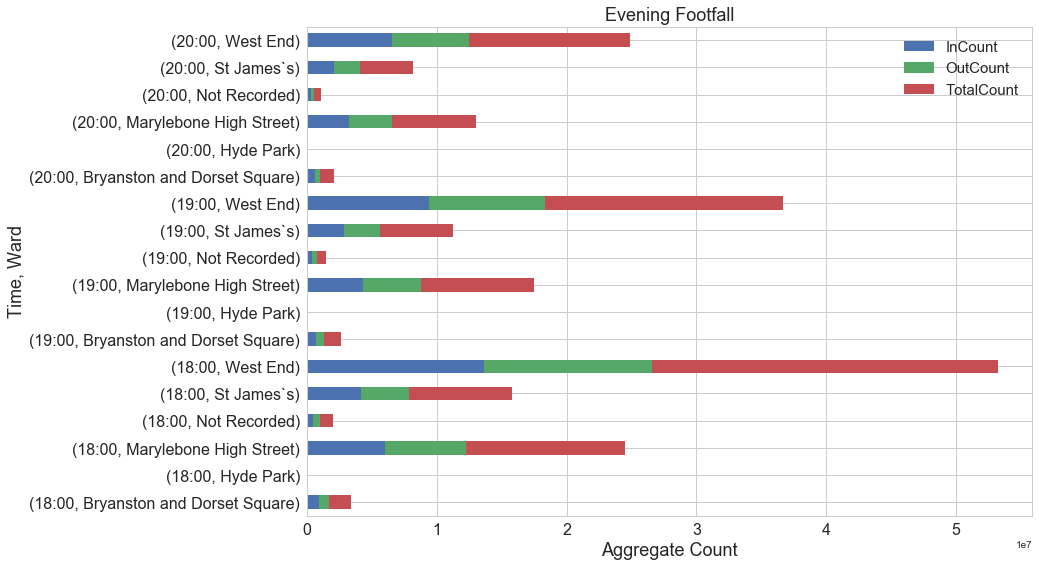

In [62]:
#plotting evening dataframe
eve_count.plot(kind='barh', stacked=True, figsize=(13,9), fontsize=16)
plt.title('Evening Footfall', fontsize=18)
plt.ylabel('Time, Ward', fontsize=18)
plt.xlabel('Aggregate Count', fontsize=18)
plt.legend(fontsize=15)

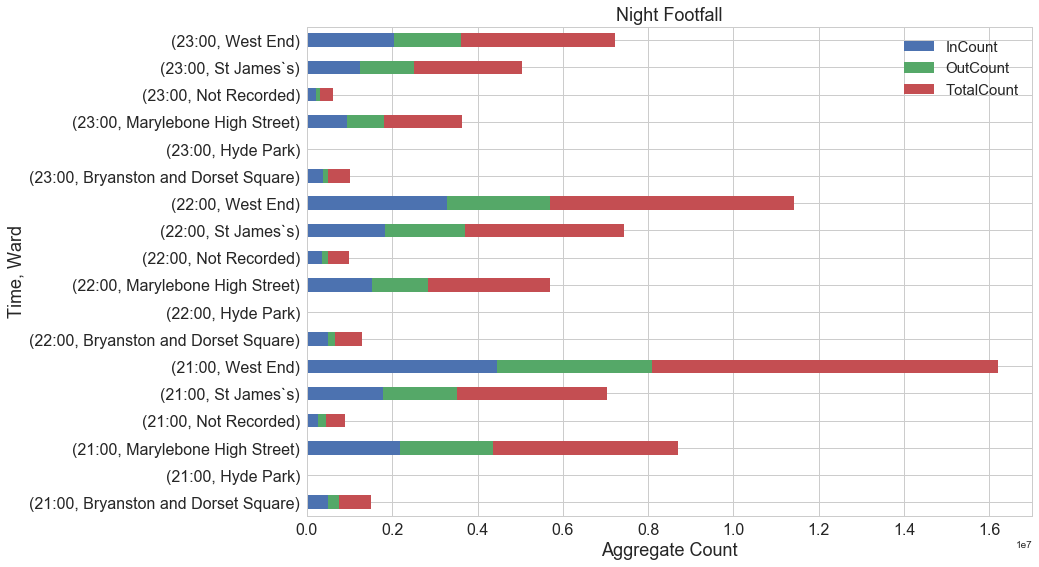

In [63]:
#plotting night dataframe
night_count.plot(kind='barh', stacked=True, figsize=(13,9), fontsize=16)
plt.title('Night Footfall', fontsize=18)
plt.ylabel('Time, Ward', fontsize=18)
plt.xlabel('Aggregate Count', fontsize=18)
plt.legend(fontsize=15)

From the above plots, it can be observed that West End ward has the highest footfall count. In the evening, the highest
count was observed around 18:00hrs, whereas in the night it was 21:00hrs

# SECTION D

# STRESS AREA FOOTFALL

Data collected is from January 2015 to March 2017

In [64]:
#create copy of footfall data
foot_df_copy = fest_df.copy()

In [65]:
#filtering the timehourband for evening economy
evening_foot  = foot_df_copy[(foot_df_copy.Time>='18:00') & (foot_df_copy.Time<='20:00')]

In [66]:
#filtering complaints made at night. That is between 20:00 and 04:00
ngt1 = foot_df_copy[(foot_df_copy.Time>'20:00') & (foot_df_copy.Time<='23:59')]
ngt2 = foot_df_copy[(foot_df_copy.Time>='00:00') & (foot_df_copy.Time<='04:00')]

In [67]:
#joining the two segments of received time to represent night-time complaints
night_foot = pd.concat([ngt1,ngt2])

In [68]:
#creating evening and night aggregated count of stress area footfall
evening_footdf= pd.DataFrame(evening_foot.groupby(['StressArea','Year'])['TotalCount'].sum())
night_footdf= pd.DataFrame(night_foot.groupby(['StressArea','Year'])['TotalCount'].sum())

In [69]:
#resetting index
evening_footdf = evening_footdf.reset_index()
night_footdf = night_footdf.reset_index()

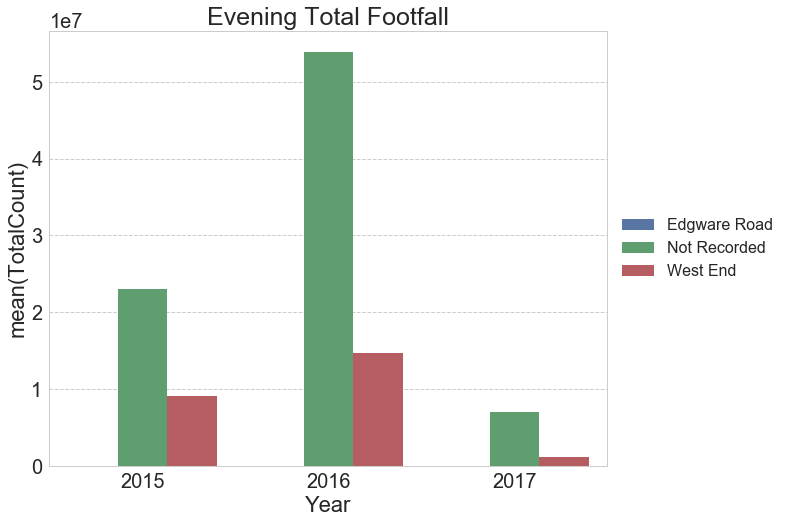

In [70]:
#creating a point plot of licenses granted for the three stress areas
plt.figure(figsize=(10,8))
sns.set(font_scale=2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.barplot(x="Year", y="TotalCount", hue="StressArea", data=evening_footdf)
plt.title('Evening Total Footfall', fontsize=25)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=16)
#saving figure
plt.savefig('/Users/jamessolomon/Desktop/plots/stress_foot_evening.png',bbox_inches="tight")

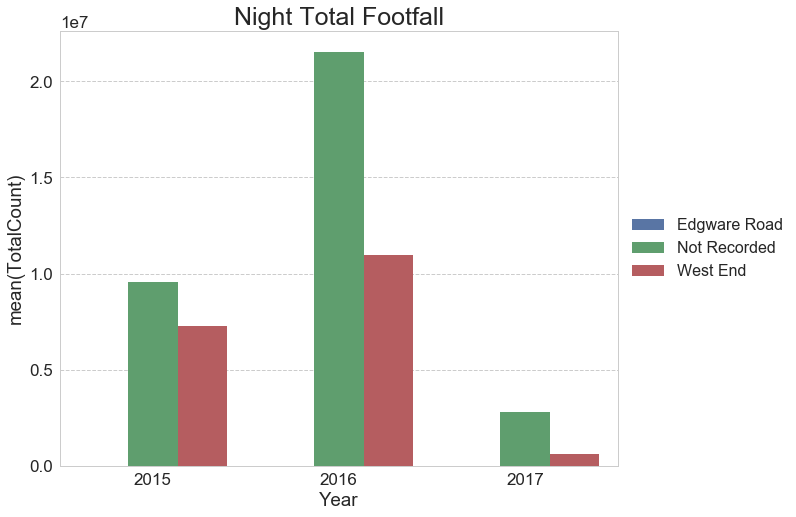

In [73]:
#creating a point plot of licenses granted for the three stress areas
fig,ax = plt.subplots(figsize=(10,8))
sns.set(font_scale=1.7)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.barplot(x="Year", y="TotalCount", hue="StressArea", data=night_footdf)
plt.title('Night Total Footfall', fontsize=25)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=16)
#saving figure
plt.savefig('/Users/jamessolomon/Desktop/plots/stress_foot_night.png',bbox_inches="tight")

In [75]:
#creating dataframe to show aggregated evening footfall for stress area
eve_group_total = pd.DataFrame(evening_footdf.groupby('StressArea')['TotalCount'].sum())

In [76]:
#printing results
eve_group_total

,TotalCount
StressArea,
Edgware Road,0
Not Recorded,83863412
West End,24954314


In [77]:
#creating dataframe to show aggregated night footfall for stress area
night_group_total = pd.DataFrame(night_footdf.groupby('StressArea')['TotalCount'].sum())

In [78]:
#printing results
night_group_total

,TotalCount
StressArea,
Edgware Road,0
Not Recorded,33882149
West End,18873824
